<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/docs/examples/multi_modal/multi_modal_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Modal RAG using Nomic Embed and Anthropic.

In this notebook, we show how to build a Multi-Modal RAG system using LlamaIndex, Nomic Embed, and Anthropic.

Wikipedia Text embedding index: [Nomic Embed Text v1.5](https://huggingface.co/nomic-ai/nomic-embed-text-v1.5)

Wikipedia Images embedding index: [Nomic Embed Text v1.5](https://huggingface.co/nomic-ai/nomic-embed-vision-v1.5)


Query encoder:
* Encoder query text for text index using Nomic Embed Text
* Encoder query text for image index using Nomic Embed Vision

Framework: [LlamaIndex](https://github.com/run-llama/llama_index)

Steps:
1. Download texts and images raw files for Wikipedia articles
2. Build text index for vector store using Nomic Embed Text embeddings
3. Build image index for vector store using Nomic Embed Vision embeddings
4. Retrieve relevant text and image simultaneously using different query encoding embeddings and vector stores
5. Pass retrieved texts and images to Claude 3

In [ ]:
%pip install llama-index-vector-stores-qdrant llama-index-multi-modal-llms-anthropic llama-index-embeddings-nomic

In [ ]:
%pip install llama_index ftfy regex tqdm
%pip install matplotlib scikit-image
%pip install -U qdrant_client
%pip install wikipedia

## Load and Download Multi-Modal datasets including texts and images from Wikipedia
Parse wikipedia articles and save into local folder

In [ ]:
from pathlib import Path
import requests

wiki_titles = [
    "batman",
    "Vincent van Gogh",
    "San Francisco",
    "iPhone",
    "Tesla Model S",
    "BTS",
]


data_path = Path("data_wiki")

for title in wiki_titles:
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "extracts",
            "explaintext": True,
        },
    ).json()
    page = next(iter(response["query"]["pages"].values()))
    wiki_text = page["extract"]

    if not data_path.exists():
        Path.mkdir(data_path)

    with open(data_path / f"{title}.txt", "w") as fp:
        fp.write(wiki_text)

## Parse Wikipedia Images and texts. Load into local folder

In [ ]:
import wikipedia
import urllib.request
from pathlib import Path
import time

image_path = Path("data_wiki")
image_uuid = 0
# image_metadata_dict stores images metadata including image uuid, filename and path
image_metadata_dict = {}
MAX_IMAGES_PER_WIKI = 30

wiki_titles = [
    "San Francisco",
    "Batman",
    "Vincent van Gogh",
    "iPhone",
    "Tesla Model S",
    "BTS band",
]

# create folder for images only
if not image_path.exists():
    Path.mkdir(image_path)


# Download images for wiki pages
# Assign UUID for each image
for title in wiki_titles:
    images_per_wiki = 0
    print(title)
    try:
        page_py = wikipedia.page(title)
        list_img_urls = page_py.images
        for url in list_img_urls:
            if url.endswith(".jpg") or url.endswith(".png"):
                image_uuid += 1
                image_file_name = title + "_" + url.split("/")[-1]

                # img_path could be s3 path pointing to the raw image file in the future
                image_metadata_dict[image_uuid] = {
                    "filename": image_file_name,
                    "img_path": "./" + str(image_path / f"{image_uuid}.jpg"),
                }

                # Create a request with a valid User-Agent header
                req = urllib.request.Request(
                    url,
                    data=None,
                    headers={
                        "User-Agent": "Mozilla/5.0 (Linux; Android 10; K) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Mobile Safari/537.36"
                    },
                )

                # Open the URL and save the image
                with urllib.request.urlopen(req) as response, open(
                    image_path / f"{image_uuid}.jpg", "wb"
                ) as out_file:
                    out_file.write(response.read())

                images_per_wiki += 1
                # Limit the number of images downloaded per wiki page to 15
                if images_per_wiki > MAX_IMAGES_PER_WIKI:
                    break

                # Add a delay between requests to avoid overwhelming the server
                time.sleep(1)  # Adjust the delay as needed

    except Exception as e:
        print(e)
        print(f"{images_per_wiki=}")
        continue

San Francisco
Batman
Vincent van Gogh
iPhone
Tesla Model S
BTS band


In [ ]:
import os

os.environ["NOMIC_API_KEY"] = ""
os.environ["ANTHROPIC_API_KEY"] = ""

## Build Multi Modal Vector Store using Text and Image embeddings under different collections

In [ ]:
import qdrant_client
from llama_index.core import SimpleDirectoryReader
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.embeddings.nomic import NomicEmbedding

# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_db")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)
embedding_model = NomicEmbedding(
    model_name="nomic-embed-text-v1.5",
    vision_model_name="nomic-embed-vision-v1.5",
)

# Create the MultiModal index
documents = SimpleDirectoryReader("./data_wiki/").load_data()
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
    embed_model=embedding_model,
    image_embed_model=embedding_model,
)

/Users/zach/Library/Caches/pypoetry/virtualenvs/llama-index-cFuSqcva-py3.12/lib/python3.12/site-packages/PIL/Image.py:3218: DecompressionBombWarning: Image size (101972528 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


### Plot downloaded Images from Wikipedia

/Users/zach/Library/Caches/pypoetry/virtualenvs/llama-index-cFuSqcva-py3.12/lib/python3.12/site-packages/PIL/Image.py:3218: DecompressionBombWarning: Image size (101972528 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


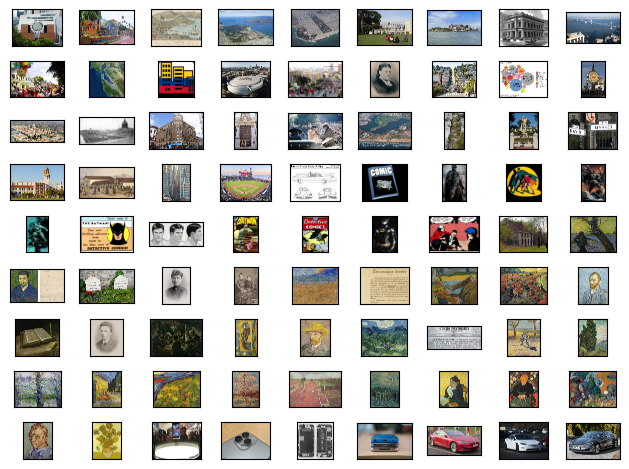

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os


def plot_images(image_metadata_dict):
    original_images_urls = []
    images_shown = 0
    for image_id in image_metadata_dict:
        img_path = image_metadata_dict[image_id]["img_path"]
        if os.path.isfile(img_path):
            filename = image_metadata_dict[image_id]["filename"]
            image = Image.open(img_path).convert("RGB")

            plt.subplot(9, 9, len(original_images_urls) + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            original_images_urls.append(filename)
            images_shown += 1
            if images_shown >= 81:
                break

    plt.tight_layout()


plot_images(image_metadata_dict)

In [ ]:
def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break

## Get Multi-Modal retrieval results for some example queries

In [ ]:
test_query = "Who are the band members in BTS?"
# generate  retrieval results
retriever = index.as_retriever(similarity_top_k=3, image_similarity_top_k=5)
retrieval_results = retriever.retrieve(test_query)

**Node ID:** 57e904ab-803b-4bf0-8d39-d4c07b80fa7a<br>**Similarity:** 0.8063886499053818<br>**Text:** BTS (Korean: 방탄소년단; RR: Bangtan Sonyeondan; lit. Bulletproof Boy Scouts), also known as the Bangtan Boys, is a South Korean boy band formed in 2010. The band consists of Jin, Suga, J-Hope, RM, Jimi...<br>

**Node ID:** 2deb16e2-d4a6-4725-9a9d-e72c910885c3<br>**Similarity:** 0.7790615531161136<br>**Text:** === Philanthropy ===

BTS are known for their philanthropic endeavors. Several members of the band have been inducted into prestigious donation clubs, such as the UNICEF Honors Club and the Green N...<br>

**Node ID:** d80dd35c-be67-4226-b0b8-fbff4981a3cf<br>**Similarity:** 0.7593813810748964<br>**Text:** == Name ==
BTS stands for the Korean phrase Bangtan Sonyeondan (Korean: 방탄소년단; Hanja: 防彈少年團), which translates literally to 'Bulletproof Boy Scouts'. According to member J-Hope, the name signifies ...<br>

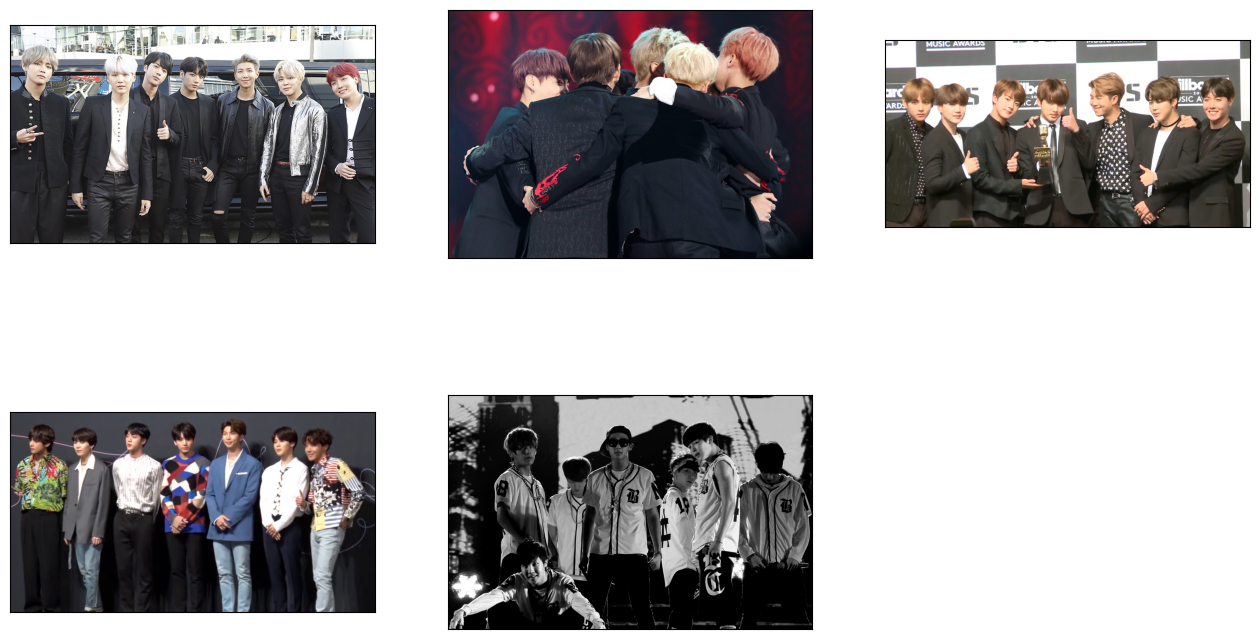

In [ ]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

**Node ID:** e385577c-b150-4ead-9758-039461125962<br>**Similarity:** 0.83218262953011<br>**Text:** Vincent Willem van Gogh (Dutch: [ˈvɪnsɛnt ˈʋɪləɱ‿vɑŋ‿ˈɣɔx] ; 30 March 1853 – 29 July 1890) was a Dutch Post-Impressionist painter who is among the most famous and influential figures in the history...<br>

**Node ID:** a3edf96b-47ca-48ec-969f-d3a47febd539<br>**Similarity:** 0.8288469749568774<br>**Text:** This novel and the 1956 film further enhanced his fame, especially in the United States where Stone surmised only a few hundred people had heard of Van Gogh prior to his surprise best-selling book....<br>

**Node ID:** 4e8de603-dac6-4ead-8851-85b4526ac8ca<br>**Similarity:** 0.8060470396548032<br>**Text:** Ten paintings were shown at the Société des Artistes Indépendants, in Brussels in January 1890. French president Marie François Sadi Carnot was said to have been impressed by Van Gogh's work.
After...<br>

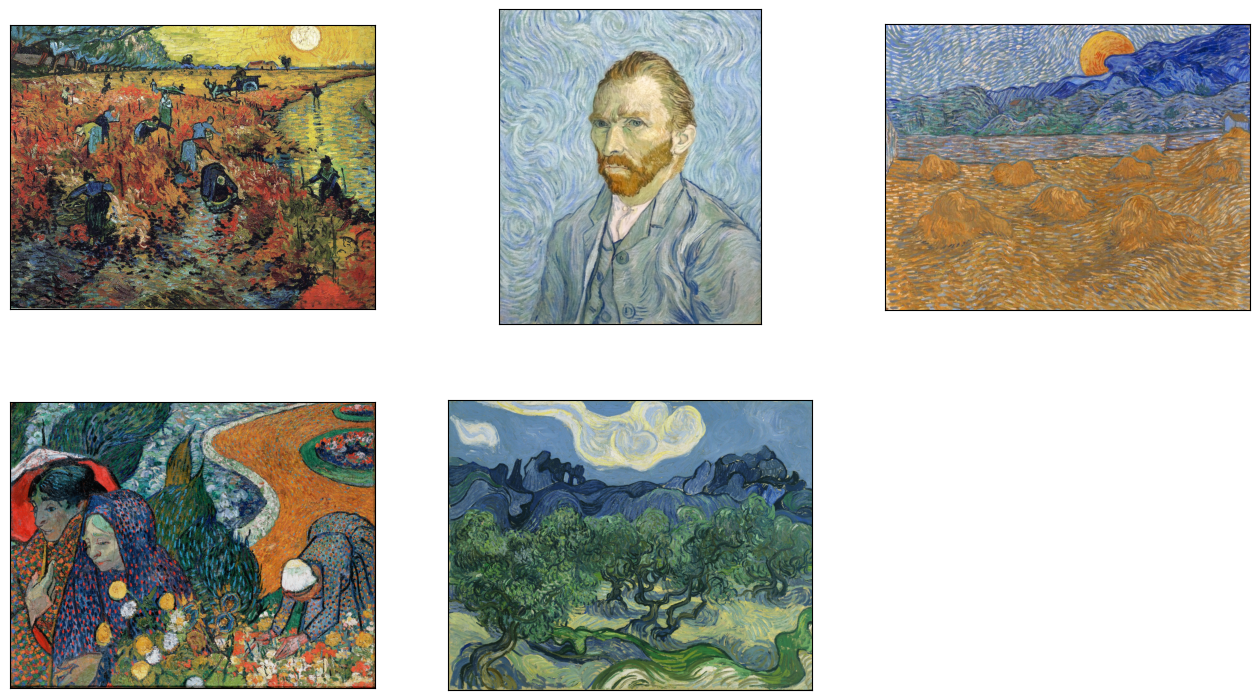

In [ ]:
test_query = "What are Vincent van Gogh's famous paintings"
# generate  retrieval results
retriever = index.as_retriever(similarity_top_k=3, image_similarity_top_k=5)
retrieval_results = retriever.retrieve(test_query)

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

**Node ID:** c2b89622-c61a-4b70-bbc1-1b3708464426<br>**Similarity:** 0.7699549146961432<br>**Text:** San Francisco was ranked fifth in the world and second in the United States on the Global Financial Centres Index as of September 2023. Despite a continuing exodus of businesses from the downtown a...<br>

**Node ID:** 0363c291-80d0-4766-85b6-02407b46e8e1<br>**Similarity:** 0.7672793963976988<br>**Text:** However, by 2016, San Francisco was rated low by small businesses in a Business Friendliness Survey.

Like many U.S. cities, San Francisco once had a significant manufacturing sector employing near...<br>

**Node ID:** 676c2719-7da8-4044-aa70-f84b8e45281e<br>**Similarity:** 0.7605001448191087<br>**Text:** == Parks and recreation ==

Several of San Francisco's parks and nearly all of its beaches form part of the regional Golden Gate National Recreation Area, one of the most visited units of the Natio...<br>

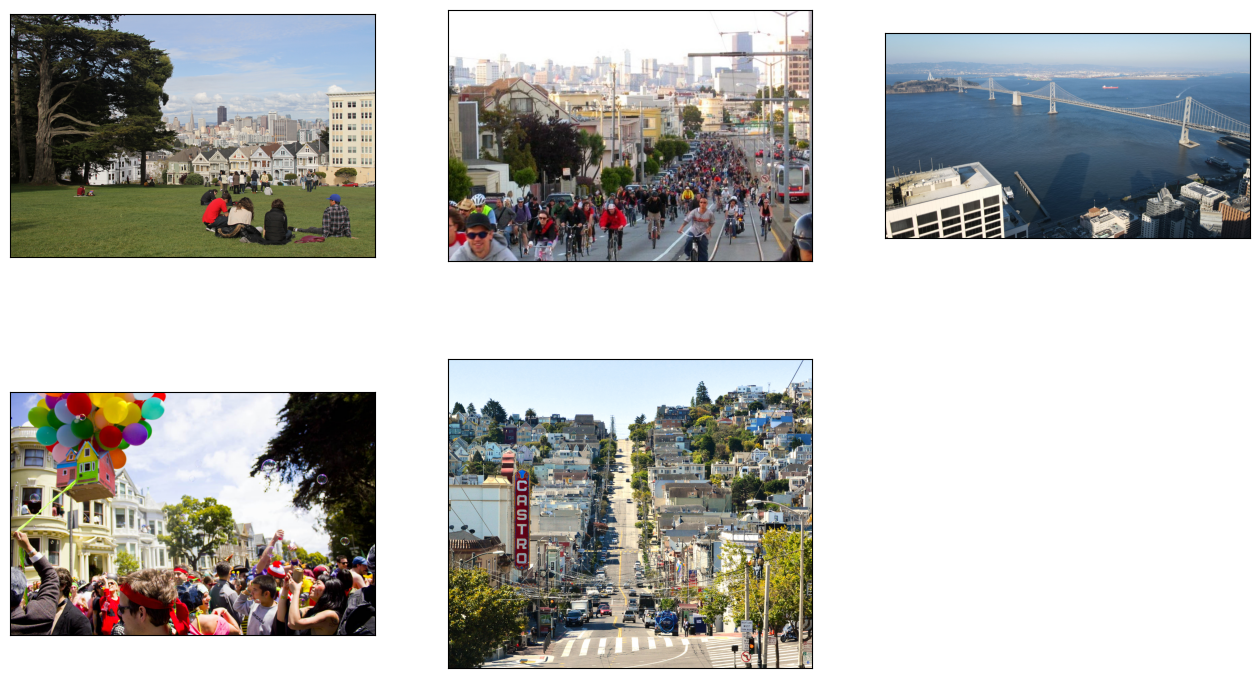

In [ ]:
test_query = "What are the popular tourist attraction in San Francisco"
# generate  retrieval results
retriever = index.as_retriever(similarity_top_k=3, image_similarity_top_k=5)
retrieval_results = retriever.retrieve(test_query)

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

**Node ID:** 63c77d12-3420-4c1c-bc35-edcf968238c0<br>**Similarity:** 0.7183866127180777<br>**Text:** The Tesla Model S is a battery electric executive car with a liftback body style built by Tesla, Inc. since 2012. The Model S features a battery-powered dual-motor, all-wheel drive layout, although...<br>

**Node ID:** 6e95a173-44b6-4837-b424-86ce223ce801<br>**Similarity:** 0.7103282638750231<br>**Text:** === Retail sales model ===

Tesla sells its cars directly to consumers without a dealer network, as other manufacturers have done and as many states require by legislation. In support of its approa...<br>

**Node ID:** 30fe5ba5-7790-44d4-a1ac-17d5ffff6e70<br>**Similarity:** 0.7057133871456653<br>**Text:** === Sales by country ===


==== Asia/Pacific ====

The first nine Australian units were delivered in Sydney on December 9, 2014. Tesla opened its first store and service centre in St Leonards, and ...<br>

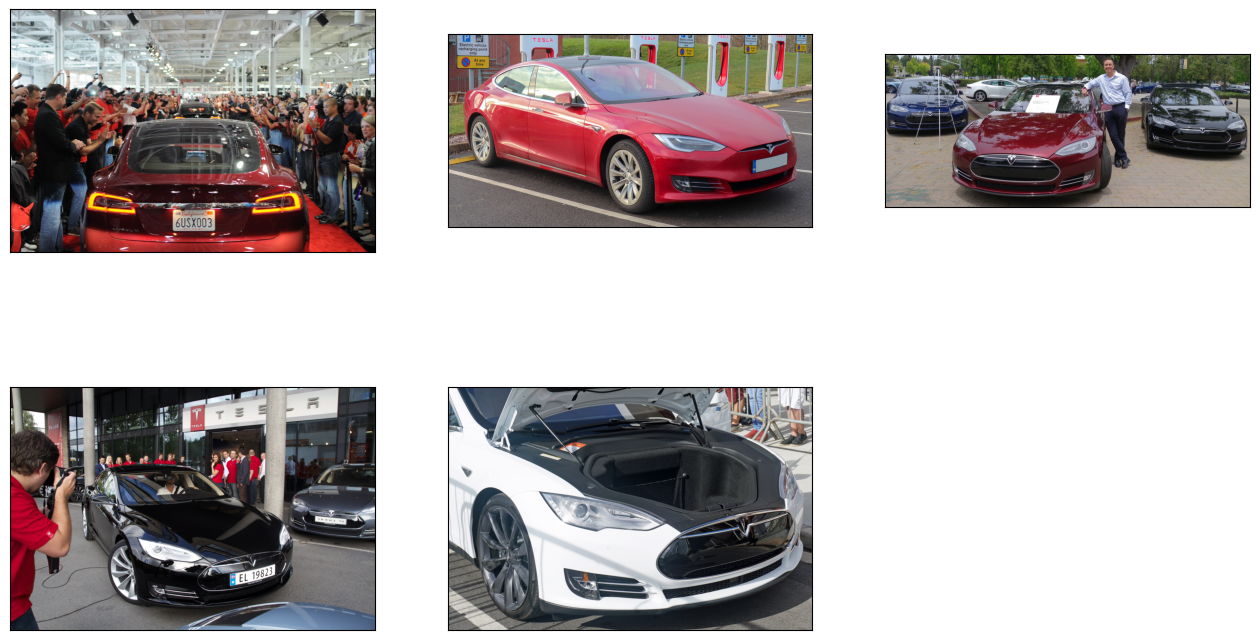

In [ ]:
test_query = "Which company makes Tesla"
# generate  retrieval results
retriever = index.as_retriever(similarity_top_k=3, image_similarity_top_k=5)
retrieval_results = retriever.retrieve(test_query)

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

**Node ID:** 9df946c8-2d86-43ef-ad49-52d02fc9ca9f<br>**Similarity:** 0.813633584027285<br>**Text:** Batman is a superhero appearing in American comic books published by DC Comics. The character was created by artist Bob Kane and writer Bill Finger, and debuted in the 27th issue of the comic book ...<br>

**Node ID:** cd23d57f-1baa-4b64-98e8-f137437f1977<br>**Similarity:** 0.8057558559295224<br>**Text:** ==== Personality ====
Batman's primary character traits can be summarized as "wealth; physical prowess; deductive abilities and obsession". The details and tone of Batman comic books have varied ov...<br>

**Node ID:** 5e49c94a-54de-493b-a31e-5cf3567a96cb<br>**Similarity:** 0.7948625863921873<br>**Text:** == Characterization ==


=== Bruce Wayne ===

Batman's secret identity is Bruce Wayne, a wealthy American industrialist. As a child, Bruce witnessed the murder of his parents, Dr. Thomas Wayne and ...<br>

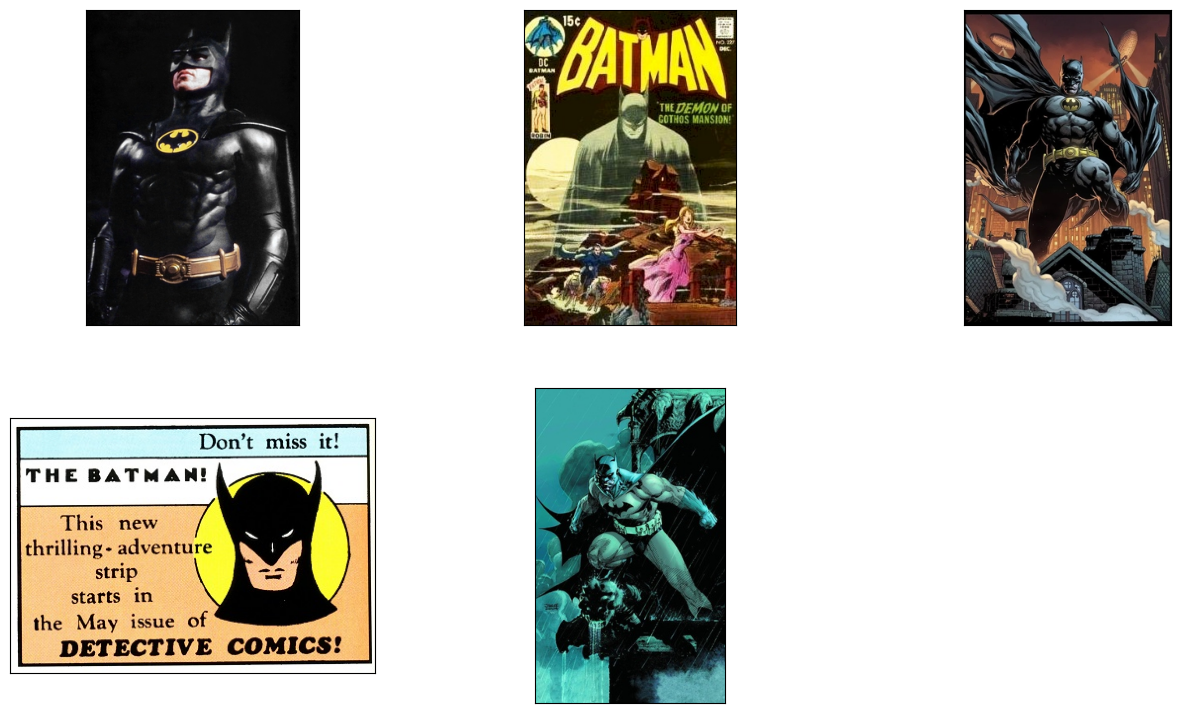

In [ ]:
test_query = "what is the main character in Batman"
# generate  retrieval results
retriever = index.as_retriever(similarity_top_k=3, image_similarity_top_k=5)
retrieval_results = retriever.retrieve(test_query)

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

## Multimodal RAG with Claude 3

Using Nomic Embed and Claude 3, we can now perform Multimodal RAG! The images and texts are passed to Claude 3 to reason over.

In [ ]:
from llama_index.multi_modal_llms.anthropic import AnthropicMultiModal

query_engine = index.as_query_engine(
    llm=AnthropicMultiModal(), similarity_top_k=2, image_similarity_top_k=1
)

In [ ]:
response = query_engine.query(
    "What are Vincent van Gogh's famous paintings and popular subjects?"
)

In [ ]:
print(str(response))

Based on the provided context, some of Vincent van Gogh's most famous paintings and popular subjects include:

- Landscapes, still lifes, portraits, and self-portraits characterized by bold colors and dramatic brushwork. This contributed to the rise of expressionism in modern art.

- In his early works, he depicted mostly still lifes and peasant laborers. 

- After moving to Arles in southern France in 1888, his paintings grew brighter and he turned his attention to depicting the natural world, including local olive groves, wheat fields and sunflowers.

- Some of his most expensive paintings that have sold for over $100 million (in today's equivalent prices) include Portrait of Dr Gachet, Portrait of Joseph Roulin, and Irises. 

- The Metropolitan Museum of Art acquired his painting Wheat Field with Cypresses in 1993 for $57 million.

So in summary, Van Gogh is especially well-known for his vibrant, expressive landscapes of places he lived like Arles, portraits, and still life painting